In [1]:
import os
import math

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import imshow, gen_goals, prepare_input, draw_samples
from scorefield.utils.diffusion_utils import bilinear_interpolate

import matplotlib.pyplot as plt


In [2]:
# Args
config_dir = "./scorefield/configs/diffusion.yaml"
args = load_config(config_dir)
device = args['device']
img_size = args['image_size']

model_path = os.path.join(args['log_path'], args['model_path'])

map_img = Image.open("map.png")
map_bounds = args['bounds']

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
        self_condition=False,
    ):
        super().__init__(
            dim=dim, 
            out_dim=out_dim, 
            dim_mults=dim_mults, 
            self_condition=self_condition,
        )

    def forward(self, obs, x_t, t, x_self_cond=None):
        score_map = super().forward(obs, t, x_self_cond)
        score = bilinear_interpolate(score_map, x_t)    # output: (B,2)
        return score
    
noise_steps = args['noise_steps']
train_lr = args['train_lr']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
    self_condition=True
).to(device)

diffusion = Diffusion(
    input_size = (2,), 
    noise_steps= noise_steps,
    device=device,
    beta_start=1e-5,
    beta_end=1e-3,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [5]:
epochs = args['epochs']
batch_size = args['batch_size']

for iters in tqdm(range(epochs)):
    optim.zero_grad()
    
    # x0 = (torch.rand(batch_size, 2, device=device, dtype=torch.float32)*2 -1.) *0.1
    x0 = gen_goals(map_bounds, batch_size, device=device)
    obs = prepare_input(map_img, img_size,  goal_pos=x0, circle_rad=2)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(obs, x_noisy, t, x_self_cond=obs)
    loss =  F.l1_loss(noise, noise_pred)
    loss.backward()
    optim.step()
    
    if iters % 1000 == 0:
        print(f"iter {iters}: {loss.item()}")


  0%|          | 0/3000 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 3.81 GiB total capacity; 2.61 GiB already allocated; 39.69 MiB free; 2.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
# torch.save(model.state_dict(), "./logs/pretrained/denoising.pt")
model.load_state_dict(torch.load('./logs/pretrained/denoising.pt'))

<All keys matched successfully>

In [12]:
x_T = torch.tensor([[-0.5, 0.5]]*10, device=device, dtype=torch.float32)
obs_T = prepare_input(args, map_img, goal_pos=x_T, circle_rad=2)

x = x_T
model.eval()
with torch.no_grad():
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        t = (torch.ones(1) * i).long().to(device)
        predicted_noise = model(obs_T, x, t)
        alpha = diffusion.alpha[t]
        alpha_hat = diffusion.alpha_hat[t]
        beta = diffusion.beta[t]
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                    * predicted_noise) + torch.sqrt(beta) * noise

299it [00:31,  9.41it/s]


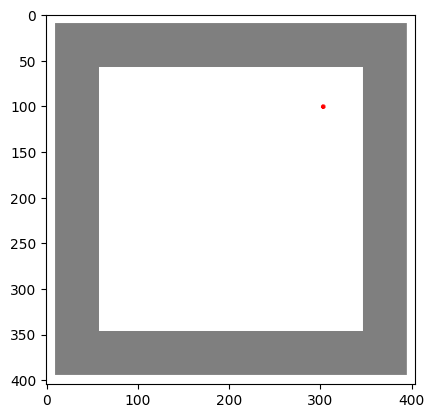

In [14]:
img_sample = draw_samples(map_img, x_T.cpu())
plt.imshow(np.array(img_sample))

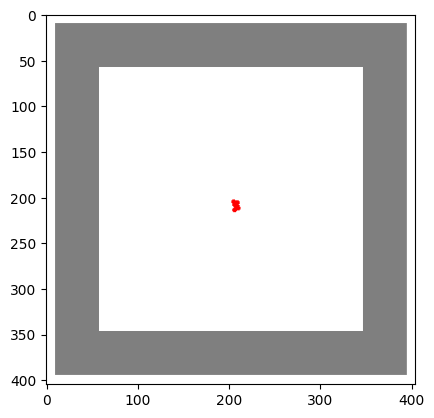

In [15]:
img_sample = draw_samples(map_img, x.cpu())
plt.imshow(np.array(img_sample))

299it [00:32,  9.29it/s]


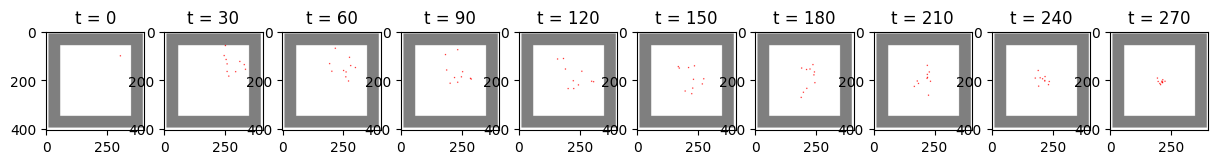

In [12]:
eval_batch_size = args['eval_batch_size']
init_state = args['init_state']

import matplotlib.pyplot as plt
import numpy as np

n = 10
fig,axs = plt.subplots(1, n, figsize=(15,15))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / n)


x_T = torch.tensor([[-0.5, 0.5]]*10, device=device, dtype=torch.float32)
obs_T = prepare_input(args, map_img, goal_pos=x_T, circle_rad=2)

x = x_T
model.eval()
with torch.no_grad():
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = draw_samples(map_img, x.cpu())
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
        
        t = (torch.ones(1) * i).long().to(device)
        predicted_noise = model(obs_T, x, t)
        alpha = diffusion.alpha[t]
        alpha_hat = diffusion.alpha_hat[t]
        beta = diffusion.beta[t]
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                    * predicted_noise) + torch.sqrt(beta) * noise